## 数据分析要求

### 一、数据摘要和可视化

#### - 数据摘要
      
      1. 标称属性，给出每个可能取值的频数
      
      2. 数值属性，给出5数概括及缺失值的个数
      
#### - 数据可视化

      使用直方图、盒图等检查数据分布及离群点
      
      
### 二、数据缺失的处理

#### - 观察数据集中缺失数据，分析其缺失的原因。分别使用下列四种策略对缺失值进行处理:
    
    1. 将缺失部分剔除
    
    2. 用最高频率值来填补缺失值
    
    3. 通过属性的相关关系来填补缺失值
    
    4.通过数据对象之间的相似性来填补缺失值

#### 注意：在处理后完成，要对比新旧数据集的差异。

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

columns = ['movieId', 'title', 'genres']
movies = pd.read_csv('/kaggle/input/movielens-10m-dataset-latest-version/ml-10M100K/movies.dat', sep='::', names=columns, engine='python')
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movies['genres'] = movies['genres'].apply(lambda x: x.split('|'))
movies['year'] = movies['title'].apply(lambda x: int(x[-5:-1]) if x[-5:-1].isdigit() else -1)
movies['title'] = movies['title'].apply(lambda s: s[:-7] if s[-5:-1].isdigit() else s)
movies.head(5)

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men,"[Comedy, Romance]",1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II,[Comedy],1995


In [ ]:
columns = ['userId','movieId', 'rating', 'timestamp']
ratings = pd.read_csv('/kaggle/input/movielens-10m-dataset-latest-version/ml-10M100K/ratings.dat', sep='::', names=columns, engine='python')
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s').dt.year
ratings.head()

,userId,movieId,rating,timestamp
0,1,122,5.0,1996
1,1,185,5.0,1996
2,1,231,5.0,1996
3,1,292,5.0,1996
4,1,316,5.0,1996


## 1. Data Details  -- Movies dataset & Ratings dataset

### Nominal Attributes

`genres` - the genres of the movies


In [ ]:
movies_genres = movies['genres']
exploded_movies_genres = movies_genres.explode('genres')
count_movies_genres  = exploded_movies_genres.value_counts()
count_movies_genres

genres
Drama                 5339
Comedy                3703
Thriller              1706
Romance               1685
Action                1473
Crime                 1118
Adventure             1025
Horror                1013
Sci-Fi                 754
Fantasy                543
Children               528
War                    511
Mystery                509
Documentary            482
Musical                436
Animation              286
Western                275
Film-Noir              148
IMAX                    29
(no genres listed)       1
Name: count, dtype: int64

经过分析，认为IMax类别、no genres listed 属于异常数据，在value_count后删去处理

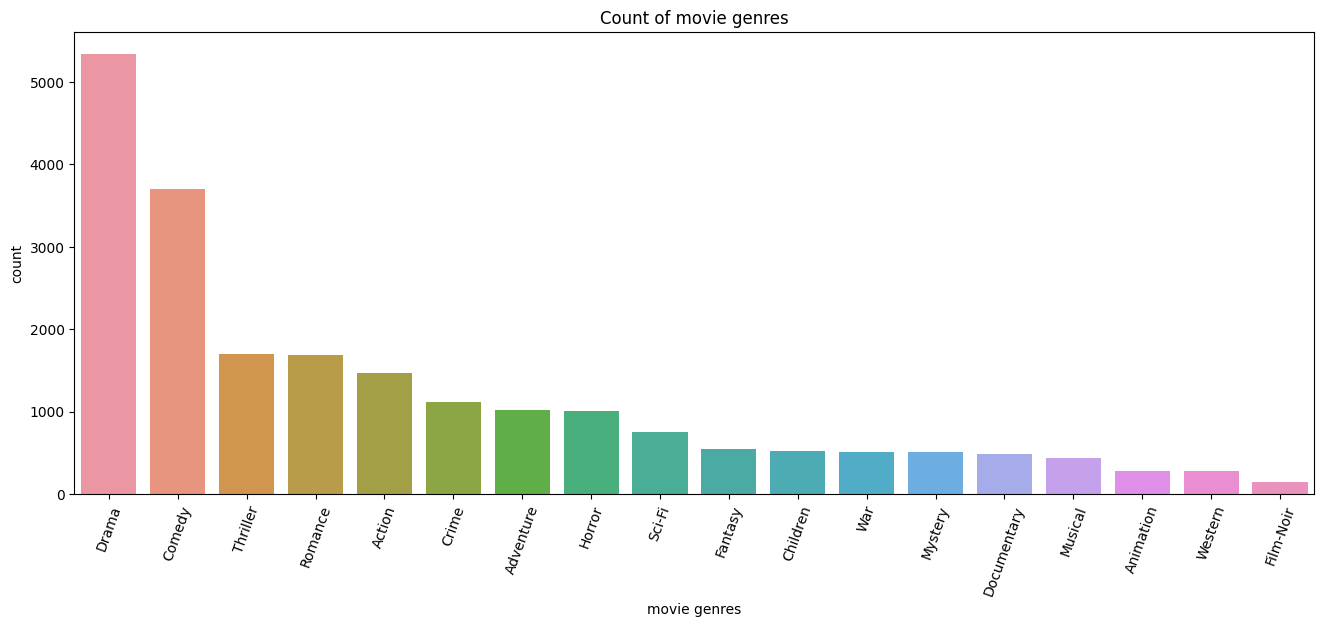

In [ ]:
count_movies_genres_process = count_movies_genres[:-2]
plt.figure(figsize=(16,6))
sns.barplot(y=count_movies_genres_process.values, x=count_movies_genres_process.index)
plt.title("Count of movie genres")
plt.xlabel("movie genres")
plt.xticks(rotation=70)
plt.ylabel("count")
plt.show()

### Numeric Attributes

`rating` - rating of the movie

`year` - year of the movie

`timestamp` - timestamp of the rating


In [ ]:
numeric_movie_data = pd.DataFrame(movies, columns=['year'])
numeric_movie_describe = numeric_movie_data.describe()
numeric_movie_describe.loc[['mean', '25%', '50%', '75%', 'max']].astype(int)

,year
mean,1986
25%,1979
50%,1994
75%,2001
max,2008


/tmp/ipykernel_33/851313466.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.hist(numeric_movie_data,bin_size[0])


Text(0.5, 1.0, 'count of movies in years')

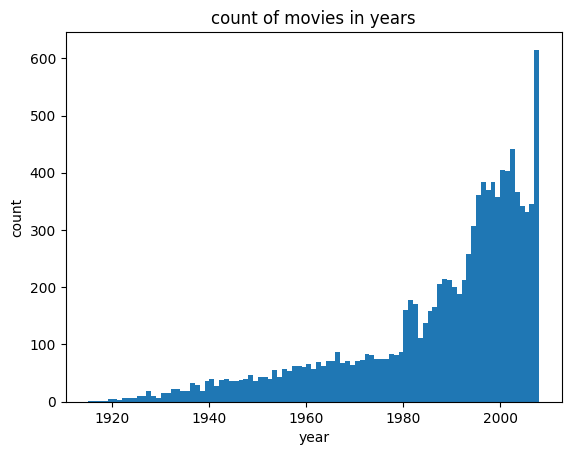

In [ ]:
bin_size = numeric_movie_data.max() - numeric_movie_data.min()
plt.hist(numeric_movie_data,bin_size[0])
plt.xlabel('year')
plt.ylabel("count")
plt.title("count of movies in years")

In [ ]:
numeric_rating_data = pd.DataFrame(ratings, columns=['rating','timestamp'])
numeric_rating_describe = numeric_rating_data.describe()
numeric_rating_describe.loc[['mean', '25%', '50%', '75%', 'max']]

,rating,timestamp
mean,3.512422,2002.199779
25%,3.000000,2000.000000
50%,4.000000,2002.000000
75%,4.000000,2005.000000
max,5.000000,2009.000000


Text(0.5, 1.0, 'count of ratings in years')

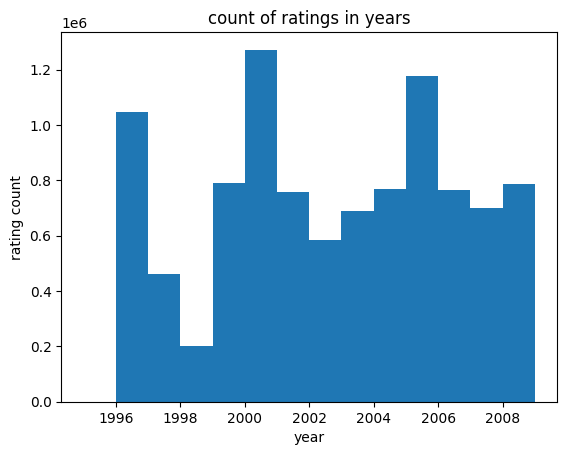

In [ ]:
bin_size = numeric_rating_data['timestamp'].max() - numeric_rating_data['timestamp'].min()
plt.hist(numeric_rating_data['timestamp'],bin_size)
plt.xlabel('year')
plt.ylabel("rating count")
plt.title("count of ratings in years")

Text(0.5, 1.0, 'ratings distributions')

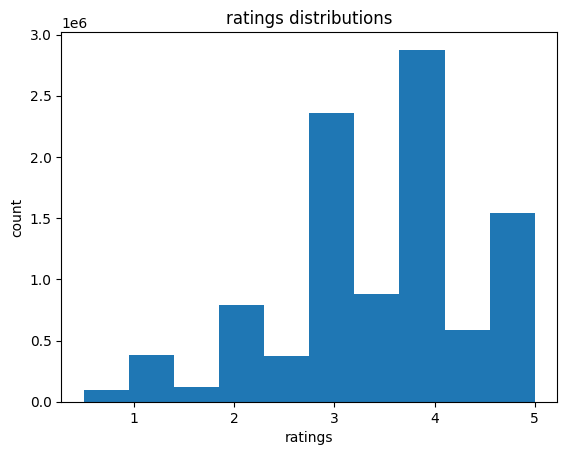

In [ ]:
plt.hist(numeric_rating_data['rating'])
plt.xlabel('ratings')
plt.ylabel("count")
plt.title("ratings distributions")

## 2. Dealing With NaN

### NaN Analysis

以primary_language列为例，其的缺乏可能是由于目录下并非某一种编程语言，可能是图书分享等文件形式，因此这一列为缺失状态，对结果的影响并不大，下面依据多种方法处理这一列的缺失数据。

    1. 将缺失部分剔除
    
    2. 用最高频率值来填补缺失值
    
    3. 通过属性的相关关系来填补缺失值
    
    4.通过数据对象之间的相似性来填补缺失值

经过统计，无空缺值，无需填充

In [ ]:
movies_NaN_counts = movies.isna().sum()
print('movies_NaN_counts:\n',movies_NaN_counts)
ratings_NaN_counts = ratings.isna().sum()
ratings_NaN_counts
print('ratings_NaN_counts:\n',ratings_NaN_counts)

movies_NaN_counts:
 movieId    0
title      0
genres     0
year       0
dtype: int64
ratings_NaN_counts:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
